In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
file_path = './stockdata3.csv'
raw_df = pd.read_csv(file_path, index_col = 'day')

raw_df.head()

,timestr,a,b,c,d,e,f
day,,,,,,,
1,09:30:00,325.450,13.795,94.500,49.985,49.93,17.025
1,09:31:00,325.245,13.890,94.515,49.990,49.96,17.025
1,09:32:00,325.580,13.905,94.565,49.995,49.96,17.025
1,09:33:00,325.470,13.955,94.645,50.065,49.92,17.025
1,09:34:00,325.295,13.975,94.580,50.030,49.90,17.025


The dataset indeed gives minute-by-minute stock price data for one full year, consisting of 252 trading days with 391 data points per day (from 9:30 am - 4:00 pm ET). However, one day ends early at 1 pm ET. (Not useful for this exercise, but this must mean that Christmas Eve fell on a weekend that year.) 

In [3]:
print(list(set(raw_df.index))[:15])

[1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 16, 17, 18, 19, 22]


In [4]:
minutes_per_day = sum(raw_df.index == 1)
print(f'Expected number of minutes per day: {minutes_per_day}.')

trading_days = len(raw_df.index.unique())
print(f'Total number of trading days: {trading_days}.')

# Find any days with a differing number of data points.
for day in raw_df.index.unique():
    if len(raw_df[raw_df.index == day]) != minutes_per_day:
        print(f'Day {day} has {len(raw_df[raw_df.index == day])} minutes of data.')
        print(raw_df[raw_df.index == day])

Expected number of minutes per day: 391.
Total number of trading days: 252.
Day 327 has 211 minutes of data.
      timestr        a      b       c       d      e      f
day                                                        
327  09:30:00  368.350  5.215  43.610  44.020  40.33  9.865
327  09:31:00  368.920  5.135  43.605  43.985  40.33  9.865
327  09:32:00  369.640  5.145  43.678  44.030  40.34  9.865
327  09:33:00  368.775  5.255  43.657  44.040  40.31  9.865
327  09:34:00  369.380  5.265  43.718  44.070  40.25  9.865
..        ...      ...    ...     ...     ...    ...    ...
327  12:56:00  364.570  5.115  43.413  43.935  40.24  9.765
327  12:57:00  364.700  5.115  43.405  43.875  40.24  9.765
327  12:58:00  364.545  5.215  43.405  43.865  40.27  9.765
327  12:59:00  364.380  5.125  43.325  43.855  40.33  9.765
327  13:00:00  363.580  5.225  43.333  43.835  40.31  9.765

[211 rows x 7 columns]


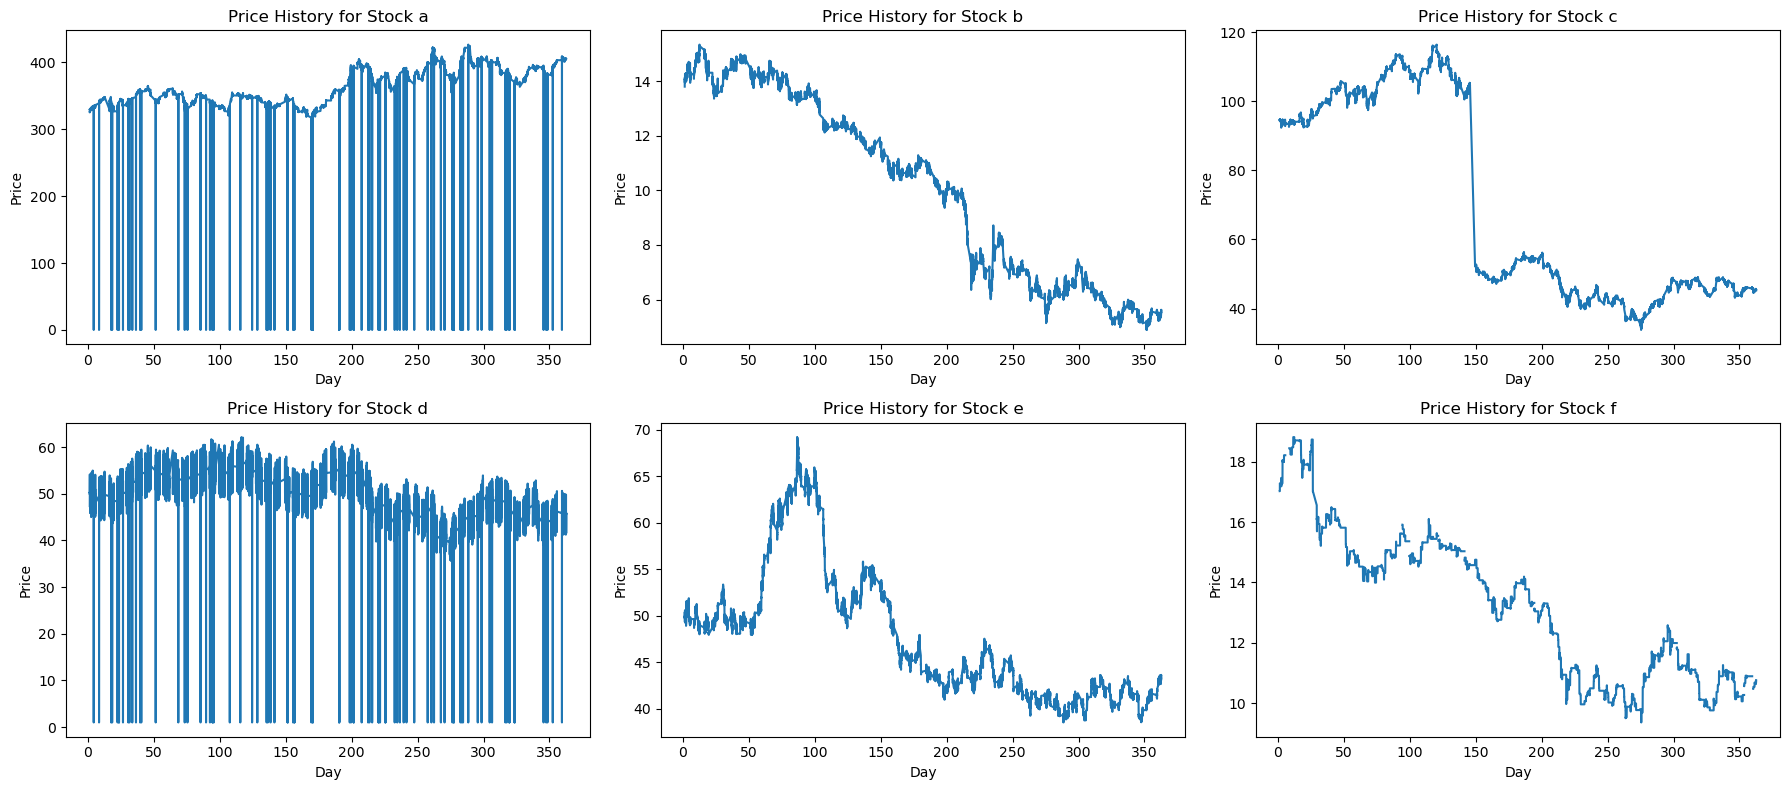

In [242]:
stocks = list('abcdef')

# Add a time column in order to plot. (Assuming timestr values are all ##:##:##) 

def timestr_to_frac(timestr):
    hour = int(timestr[:2])
    minute = int(timestr[3:5])
    return hour/24 + minute/(24*60)
raw_df['timedelta'] = raw_df['timestr'].apply(timestr_to_frac)

def compact_plot(df, data=None, title=None, axis_label=None, rolling_std=None, filename=None):
    # Make smaller plots for readability. 
    # 'axes' is an ndarray of shape (2,3). We flatten for ease of iterability. 
    fig, axes = plt.subplots(2, 3, figsize=(18, 8))
    axes = axes.flatten()
    
    for i, stock in enumerate(stocks):
        if not data:
            x_values = df.index
        else:
            x_values = df.index + df['timedelta']

        # Note that we are linearly connecting the market end and start times in the plot. 
        # This is only graphical; it has no effect on later analysis. 
        subplot = axes[i]
        subplot.plot(x_values, df[stock])

        # Check if rolling standard deviation data is provided and plot it along with second y-axis
        if rolling_std is not None:
            new_plot = subplot.twinx()
            new_plot.plot(x_values, rolling_std[stock], label='Rolling Std Dev', color='red', linestyle='--')
            new_plot.set_ylabel('Std Dev')
            new_plot.tick_params(axis='y', labelcolor='red')

        subplot.set_xlabel('Day')
        if axis_label:
            subplot.set_ylabel(axis_label)
        else:
            subplot.set_ylabel('Price')
        if title:
            subplot.set_title(title + f' for Stock {stock}')
        else:
            subplot.set_title(f'Price History for Stock {stock}')
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename)
        
    plt.show()
    return
compact_plot(raw_df, data='raw', title='Price History', filename='raw_df.png')

We also plot data for a single day to get a closer look at any intraday oddities. 

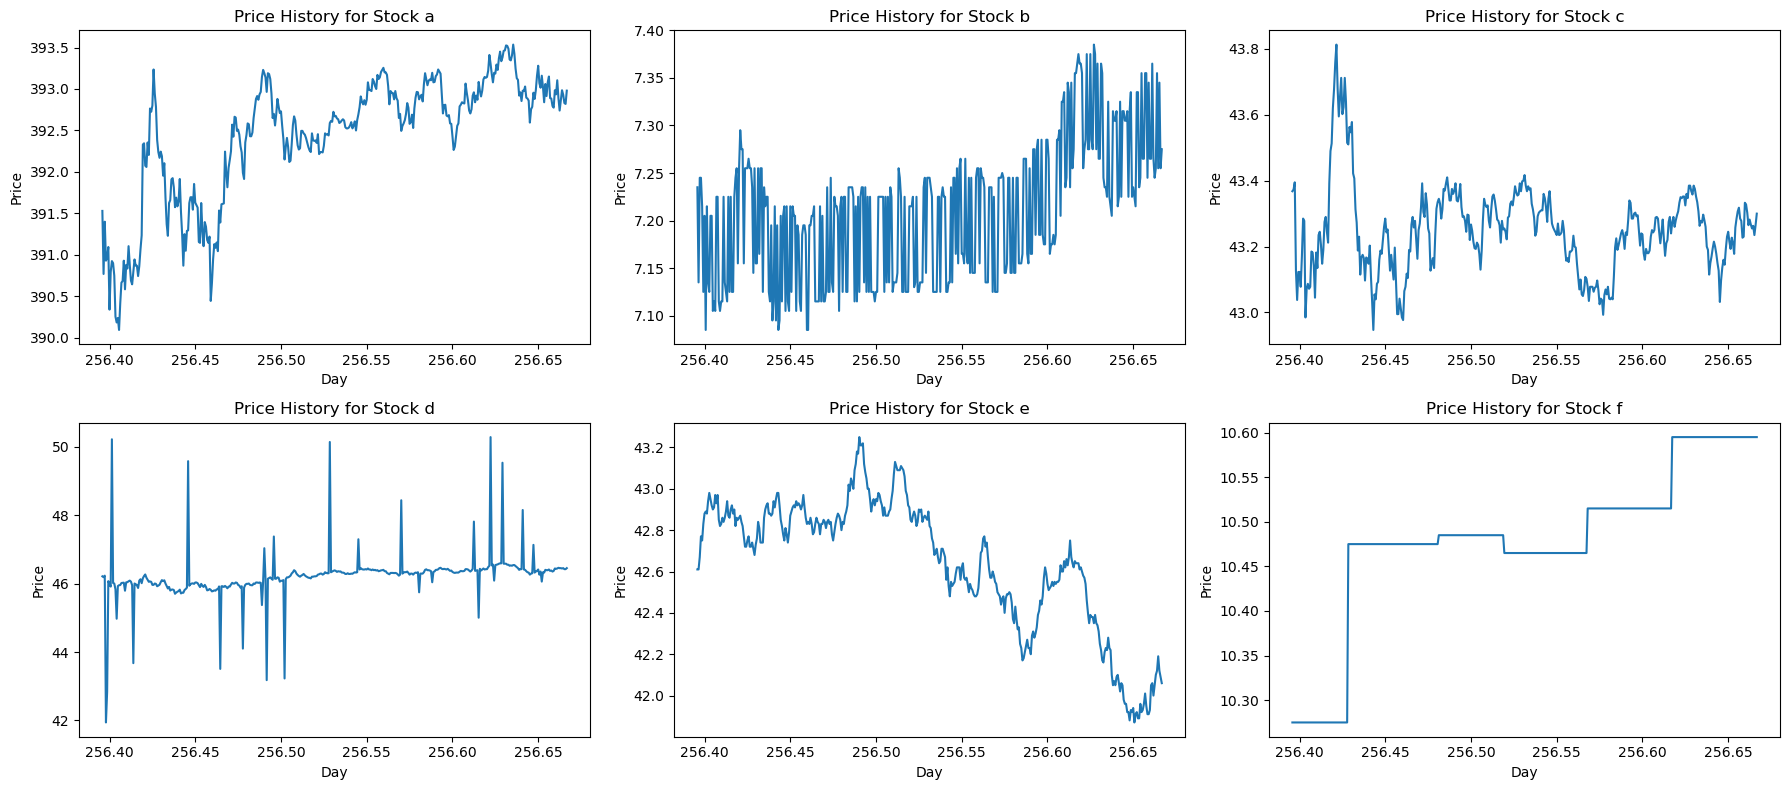

In [243]:
compact_plot(raw_df.loc[256], data='raw', filename='raw_df_day_256.png')

Some quick observations we can make: Stocks a and d seem to have erroneously input values of 0 and 1, respectively; Stocks a, c, d, and f are missing some values; Stock c appears to have undergone a 2:1 stock split over Memorial Day weekend; Stock f has low trading volume; Stock b seems to be the target of HFT with a rather large spread of ~1.5%; Stock d might be riddled with bad data -- it is difficult to believe that errant trades can be followed by immediate, precise corrections so regularly for a stock that seems to be not illiquid. 

We first follow up more carefully on some of these observations. 

In [8]:
print(f'Expected data points per stock: {len(raw_df)}.')
raw_df.describe()

Expected data points per stock: 98352.


,a,b,c,d,e,f,timedelta
count,98281.000000,98352.000000,98321.000000,98334.000000,98352.000000,96981.000000,98352.000000
mean,363.767737,10.048836,69.445570,49.803747,47.727738,13.204838,0.531116
std,28.281333,3.332643,28.675762,4.539923,7.053875,2.404705,0.078377
min,0.000000,4.885000,33.807000,1.000000,38.550000,9.365000,0.395833
25%,341.785000,6.605000,45.330000,46.175000,42.040000,10.945000,0.463194
50%,357.915000,10.595000,50.960000,50.105000,45.410000,13.325000,0.531250
75%,387.890000,13.465000,101.905000,53.735000,51.350000,15.035000,0.599306
max,426.560000,15.335000,116.385000,62.137000,69.210000,18.815000,0.666667


We inspect and confirm the possible input errors for Stocks a and d. 

In [9]:
print(len(raw_df['a'][(300 > raw_df['a']) & (raw_df['a'] > 0)]))
print(len(raw_df['d'][(30 > raw_df['a']) & (raw_df['a'] > 1)]))

0
0


We inspect the sudden shift in value of Stock c in the following two cells. 

In [10]:
print(raw_df[raw_df['c'] > 70].index[-1])
print(raw_df[raw_df['c'] < 70].index[0])

145
149


In [11]:
print([day in raw_df.index for day in range(146,149)])
print(raw_df['c'].loc[145].iloc[-1])
print(raw_df['c'].loc[149].iloc[0])

[False, False, False]
104.594
53.265


We inspect the rather large gaps in the data for Stock f and find that there is missing price data for stretches of time, though none span an entire trading day. 

In [12]:
# Determine the lengths of consecutive missing values in column 'f'

missing_f_data = raw_df['f'].isnull()
missing_f_data = missing_f_data.groupby(raw_df['f'].notnull().cumsum()).sum()
missing_f_data = missing_f_data[missing_f_data > 0]
missing_f_data

f
1865     427
25070      2
26413     23
32169     97
34342     96
37401    127
41238     31
51607     23
69414    258
80727     69
94646     33
95951    185
Name: f, dtype: int64

At this point we must decide on how we want to clean and modify our data. The modifications we choose are dependent on which model we intend to use. As we wish to forecast volatility a month out from the end period of the given data, we opt to utilize daily closing prices and a GARCH model. Thus, we must be mindful of the effects of our alterations on the raw closing price data. 

We fill in any missing or erroneous data using the last posted price for each stock. For Stocks a and d, values of 0 or 1 are clearly errors. Additionally for Stock d, we choose to identify as errors those data points which fall outside a rolling interval constructed using quartile ranges. 

We replace data for Stock b with a moving average of the last 10 minutes of price data in order to reduce the effects of the bid-ask spread on long term volatility predictions. For Stock c, we adjust the price before the stock split. 

Days whose closing values of Stock d were modified: [4, 10, 122, 155, 191, 262, 285, 291, 330]


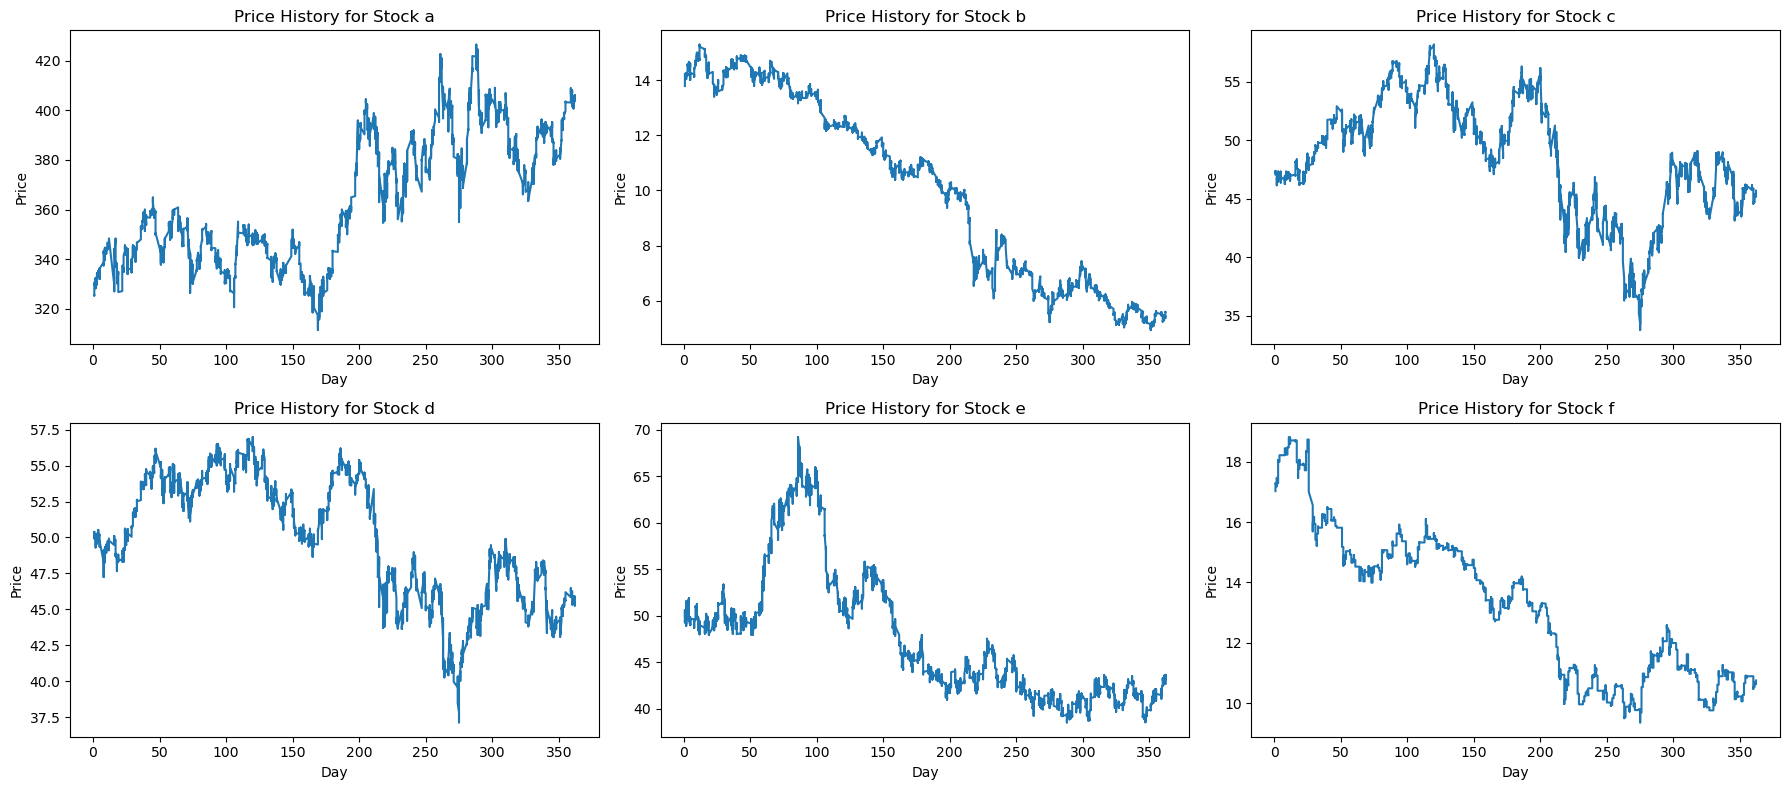

In [244]:
df = raw_df.copy()

# Replace bad data for Stocks a and d
df.replace({0: np.nan, 1: np.nan}, inplace=True)

# Fill any NaNs with previous values
df.ffill(inplace=True)


# Find and replace outliers in Stock d prices according to quantile range for each day
def replace_d_outliers(df): 
    # Parameters chosen after multiple tests
    threshold = 3
    window_size = 30
    percentile = .25

    # Forward and past ranges used to handle open and closing data points
    q1 = df['d'].rolling(window=window_size).quantile(percentile)
    q3 = df['d'].rolling(window=window_size).quantile(1 - percentile)
    iqr = abs(q3 - q1)
    outliers = (df['d'] < q1 - threshold*iqr) | (df['d'] > q3 + threshold*iqr)

    df_rev = df.iloc[::-1]
    q1_for = df_rev['d'].rolling(window=window_size).quantile(percentile).iloc[::-1]
    q3_for = df_rev['d'].rolling(window=window_size).quantile(1 - percentile).iloc[::-1]
    iqr_for = abs(q3_for - q1_for)
    outliers |= (df['d'] < q1_for - threshold*iqr_for) | (df['d'] > q3_for + threshold*iqr_for)

    df.loc[outliers, 'd'] = pd.NA
    df = df.ffill()
    return df.bfill()

df = df.groupby(df.index, group_keys=False).apply(replace_d_outliers)

# We check which closing prices were modified
modified = (raw_df['d'] != df['d'])
modified = modified.groupby(modified.index).apply(lambda x: x.iloc[-1])
print(f'Days whose closing values of Stock d were modified: {modified[modified].index.to_list()}')


# Replace price of b with moving average
window_size = 10
df['b'] = df.groupby(df.index).rolling(window=window_size, min_periods=1)['b'].mean().values


# Adjust the price of c before the split
df.loc[df.index < 146, 'c'] /= 2

compact_plot(df, filename='clean_prices.png')

Our data now looks quite clean. We see that had we not eliminated outliers from Stock d's data, we would likely end up overestimating forecasted variance using closing price data. 

We would like to use an ARMA-EGARCH model to model log returns and conditional variances of the innovations of the log returns for each stock separately. From visual inspection of the graphs, we see that there is likely nontrivial amounts of correlation between many of the stocks (day 275 looks like it might have been a bad day for the market at large). It would be wise then to use a multivariate GARCH model that captures asymmetry in price shocks. We stumbled upon DCC-GARCH, though implementations are scattered across various R-packages, so we first focus on univariate models. 

We now form and visualize the daily closing log returns series and rolling monthly volatility of the log return series for each stock in order to assess whether an ARMA-EGARCH model is sensible. 

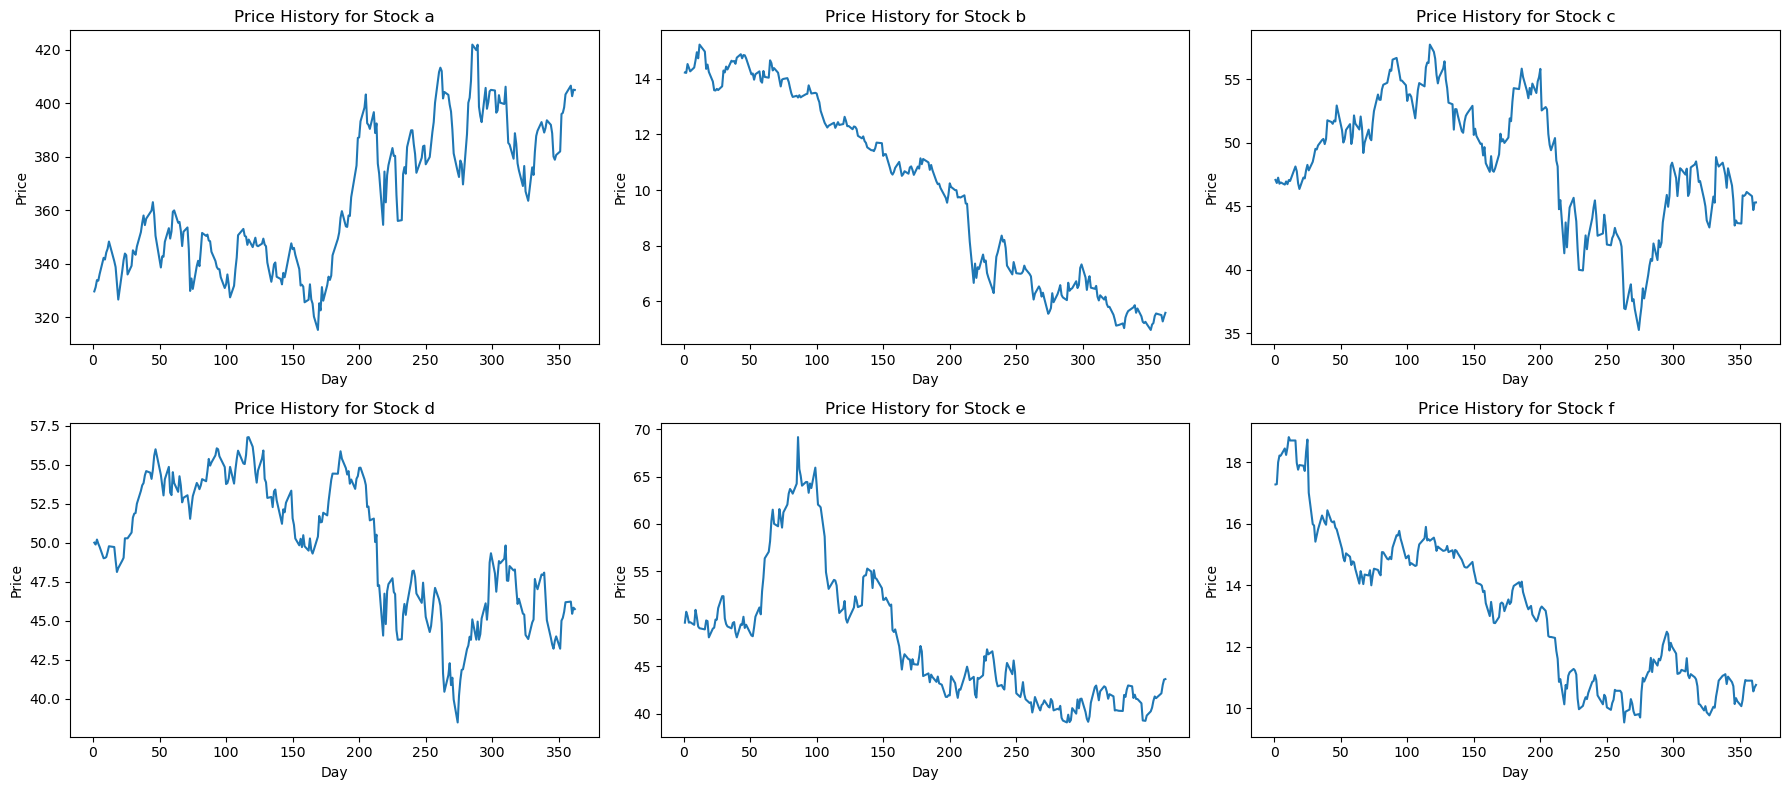

In [23]:
df_close = df.groupby(df.index).apply(lambda x: x.iloc[-1])[stocks]
compact_plot(df_close)

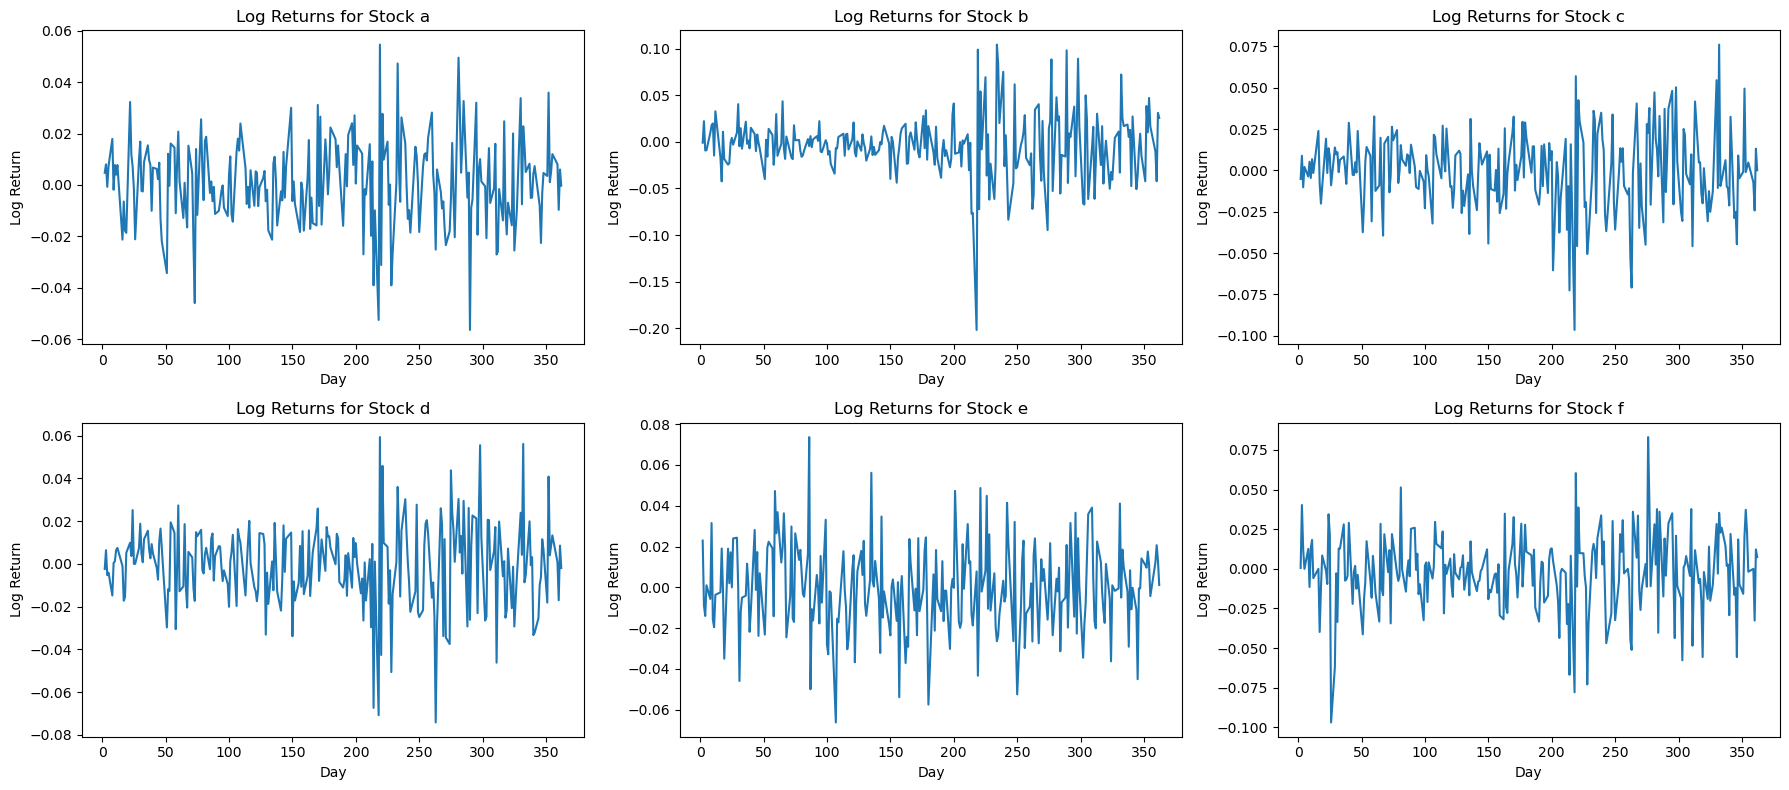

In [245]:
r = (np.log(df_close).diff()).dropna()
compact_plot(r, title='Log Returns', axis_label='Log Return', filename='log_returns.png')

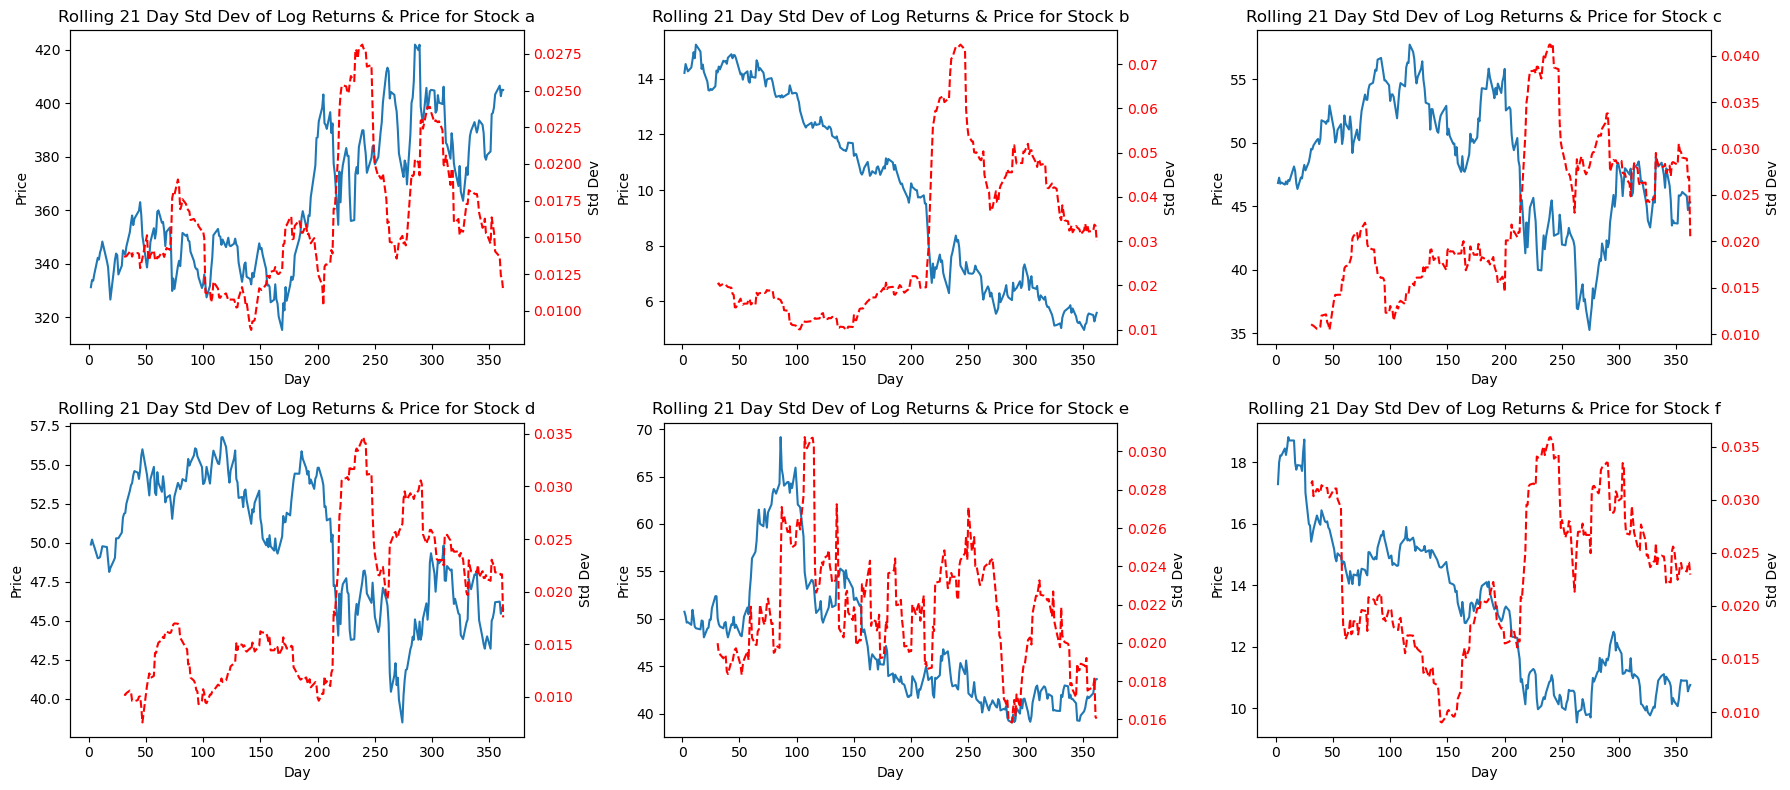

In [246]:
compact_plot(df_close.iloc[1:], title='Rolling 21 Day Std Dev of Log Returns & Price', rolling_std=r.rolling(window=21, min_periods=21).std(), filename='rolling_std.png')

The above plots indicate persistence of effects of price shocks on rolling realized volatility and asymmetry in the effects of positive versus negative price shocks, suggesting that EGARCH models are appropriate. 

To formally test for ARCH effects in the log return series, we use Engle's Lagrange multiplier test, which is implemented in the 'het_arch' method of 'statsmodel.stats.diagnostic'. In order to use this, we first need to fit ARMA models onto the series, and so we first need to statistically confirm the stationarity of our series. 

We use the augmented Dickey-Fuller test to detect the presence of a unit roots in the log returns -- the rejection of this hypothesis implies stationarity.

In [39]:
from statsmodels.tsa.stattools import *
from statsmodels.graphics.tsaplots import * 
from statsmodels.stats.diagnostic import *


for stock in stocks:
    print(f'ADF test for stock {stock}:')
    print(adfuller(r[stock], autolag='AIC'), '\n')

ADF test for stock a:
(-15.351897330932742, 3.7104968284511048e-28, 0, 250, {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544}, -1250.1361260956132) 

ADF test for stock b:
(-8.524641209167617, 1.0773975765397521e-13, 5, 245, {'1%': -3.4573260719088132, '5%': -2.873410402808354, '10%': -2.573095980841316}, -924.4349648225332) 

ADF test for stock c:
(-16.284547581199575, 3.3858516982618816e-29, 0, 250, {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544}, -1074.1708142437426) 

ADF test for stock d:
(-9.91916278788588, 3.0231687180729976e-17, 2, 248, {'1%': -3.4569962781990573, '5%': -2.8732659015936024, '10%': -2.573018897632674}, -1167.8546550971937) 

ADF test for stock e:
(-15.055260152610353, 9.169758267086585e-28, 0, 250, {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544}, -1120.8404786316323) 

ADF test for stock f:
(-14.921231430425665, 1.4105914775612751e-27, 0, 250, {'1%': -3.456780859712, '5%': -2.8731715065600003,

We plot ACF and PACF graphs for each return series to get an idea of the values of the hyperparameters 'p' and 'q' we should use in the ARMA processes to model the conditional means of the log return series. However, we ultimately perform a grid search over hyperparameter values and use the AIC to determine the best model. 

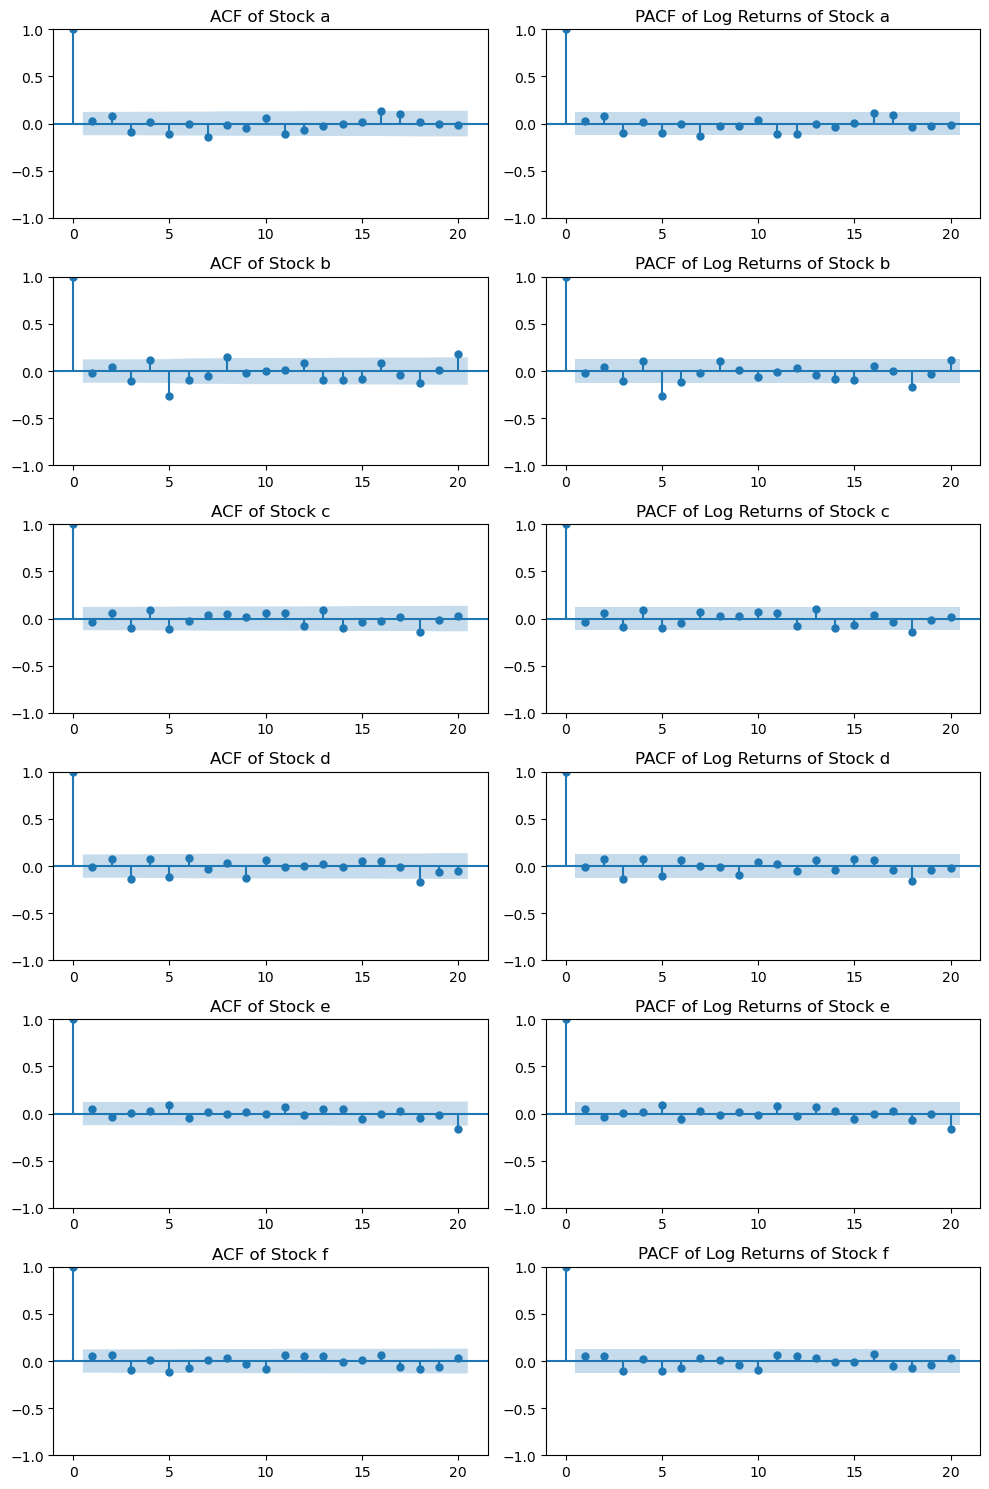

In [113]:
fig, axes = plt.subplots(6, 2, figsize=(10, 15))
axes = axes.flatten(order='F')

for i, stock in enumerate(stocks):
    plot_acf(r[stock], ax=axes[i], lags=20)
    axes[i].set_title(f'ACF of Stock {stock}')

    plot_pacf(r[stock], ax=axes[i+6], lags=20)
    axes[i+6].set_title(f'PACF of Log Returns of Stock {stock}')
plt.tight_layout()
plt.show()

In [234]:
from itertools import product
from statsmodels.tsa.arima.model import ARIMA
from arch import *

# Function for determining best ARMA(p,q) or AR-EGARCH(lag,p,o,q) model
def grid_search_aic(log_returns, p_range, q_range, lag_range=None, o_range=None, vol='GARCH'):
    best_models = {}
    for stock in stocks:
        best_aic = float('inf')
        best_model = None

        # Create combinations of hyperparameters
        if lag_range: # If fitting AR-(E)GARCH
            hyperparams = product(lag_range, p_range, o_range, q_range)
        
            for lag, p, o, q in hyperparams:
                # Fit EGARCH model to the residuals
                model = arch_model(log_returns[stock], mean='AR', lags=lag, vol=vol, p=p, o=o, q=q, rescale=False)
                fitted_model = model.fit(disp='off', tol=1e-20, options={'maxiter':300})
    
                # Calculate AIC
                aic = fitted_model.aic
    
                # Update best model if lower AIC is found
                if aic < best_aic:
                    best_aic = aic
                    best_model = fitted_model
        
        else: # Else, fitting ARMA
            hyperparams = product(p_range, q_range)

            for p, q in hyperparams:
                # Make bounds on parameter values to deal with convergence and non-stationarity and non-invertibiility warnings
                bounds = [(None, None)] + [(-0.99, 0.99)]*p + [(-10, 10)]*q + [(None,None)] # First and last are mean and var
                model = ARIMA(log_returns[stock], order=(p,0,q))
                fitted_model = model.fit(method_kwargs = {'bounds':bounds})

                # model = ARIMA(log_returns[stock], order=(p,0,q)).fit()
    
                aic = fitted_model.aic

                if aic < best_aic:
                    best_aic = aic
                    best_model = fitted_model
                    
        best_models[stock] = best_model

    return best_models

In [105]:
# Need to convert index into datetime objects to make statsmodels happy
# Pick arbitrary starting day
start_date = pd.to_datetime('2024-01-01')
dates = pd.date_range(start=start_date, periods=len(orig_r_index)+1, freq='D')[1:]
new_r = r.copy()
new_r.index = dates

In [ ]:
arma_models = grid_search_aic(new_r, range(20),[0])

In [153]:
for stock in stocks:
    print(arma_models[stock].summary())

                               SARIMAX Results                                
Dep. Variable:                      a   No. Observations:                  251
Model:                          ARIMA   Log Likelihood                 675.757
Date:                Sun, 05 May 2024   AIC                          -1347.514
Time:                        16:45:14   BIC                          -1340.463
Sample:                    01-02-2024   HQIC                         -1344.676
                         - 09-08-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.786      0.432      -0.001       0.003
sigma2         0.0003   1.95e-05     13.770      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.17   Jarque-

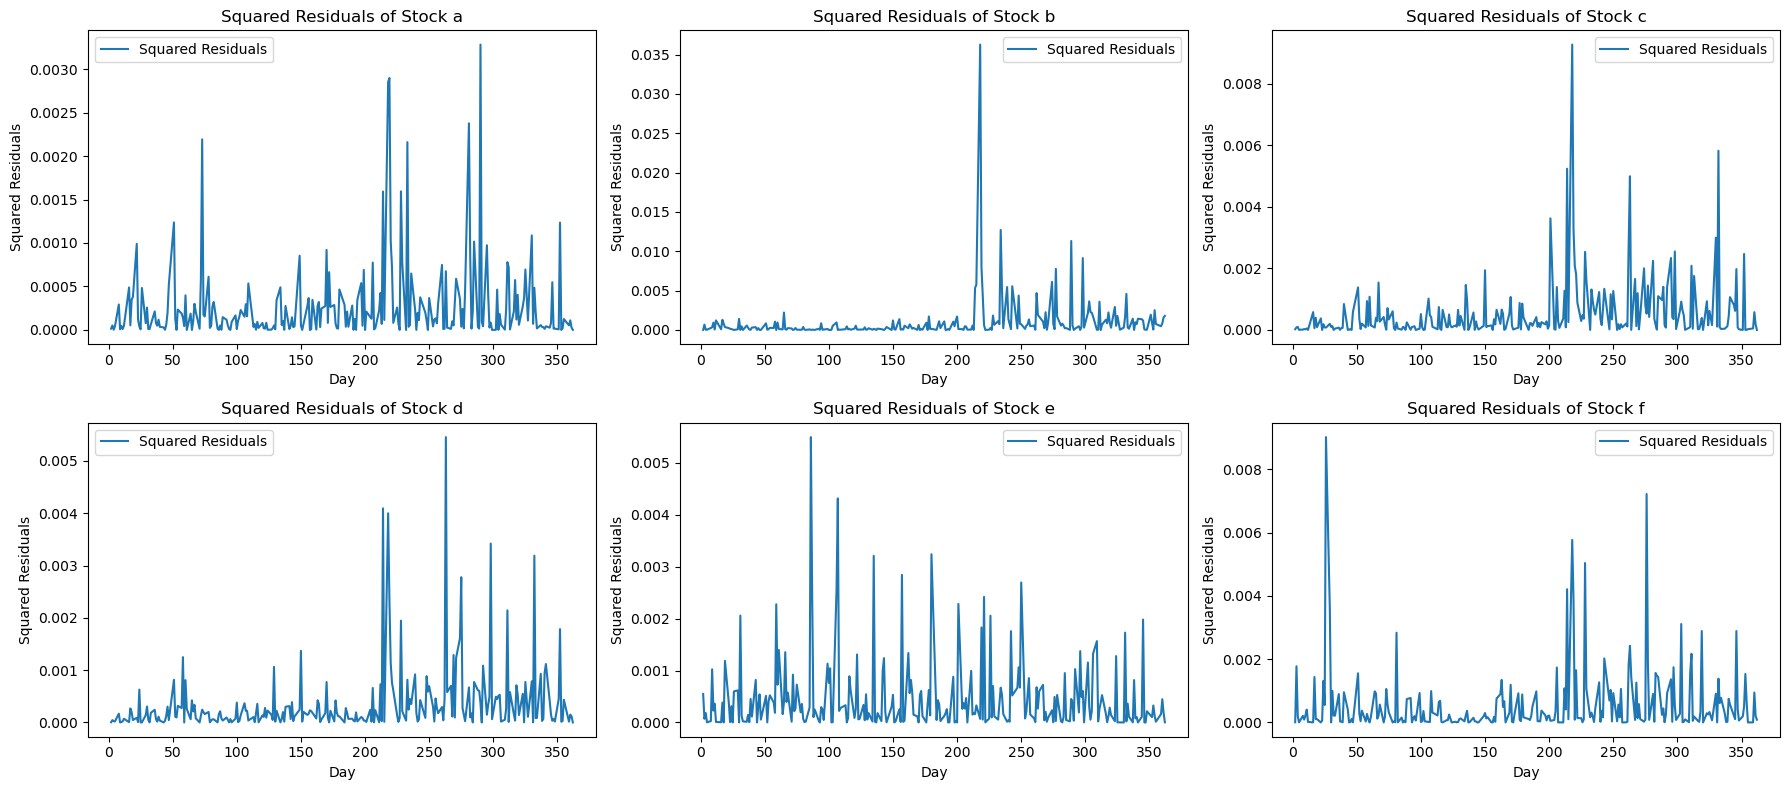

In [157]:
fig, axes = plt.subplots(2,3, figsize=(18, 8))
axes = axes.flatten()

# for i, model in enumerate(arma_models):
for i, stock in enumerate(stocks):
    # Calculate squared residuals
    # residuals_squared = model.resid**2
    residuals_squared = arma_models[stock].resid**2

    
    axes[i].plot(r.index, residuals_squared, label='Squared Residuals')
    axes[i].set_title(f'Squared Residuals of Stock {stocks[i]}')
    axes[i].set_xlabel('Day')
    axes[i].set_ylabel('Squared Residuals')
    axes[i].legend()

plt.tight_layout()
plt.show()


Below we graph the ACF and PACF of the squared residuals of the fitted AR(p) models, again to demonstrate the likely presence of ARCH effects. 

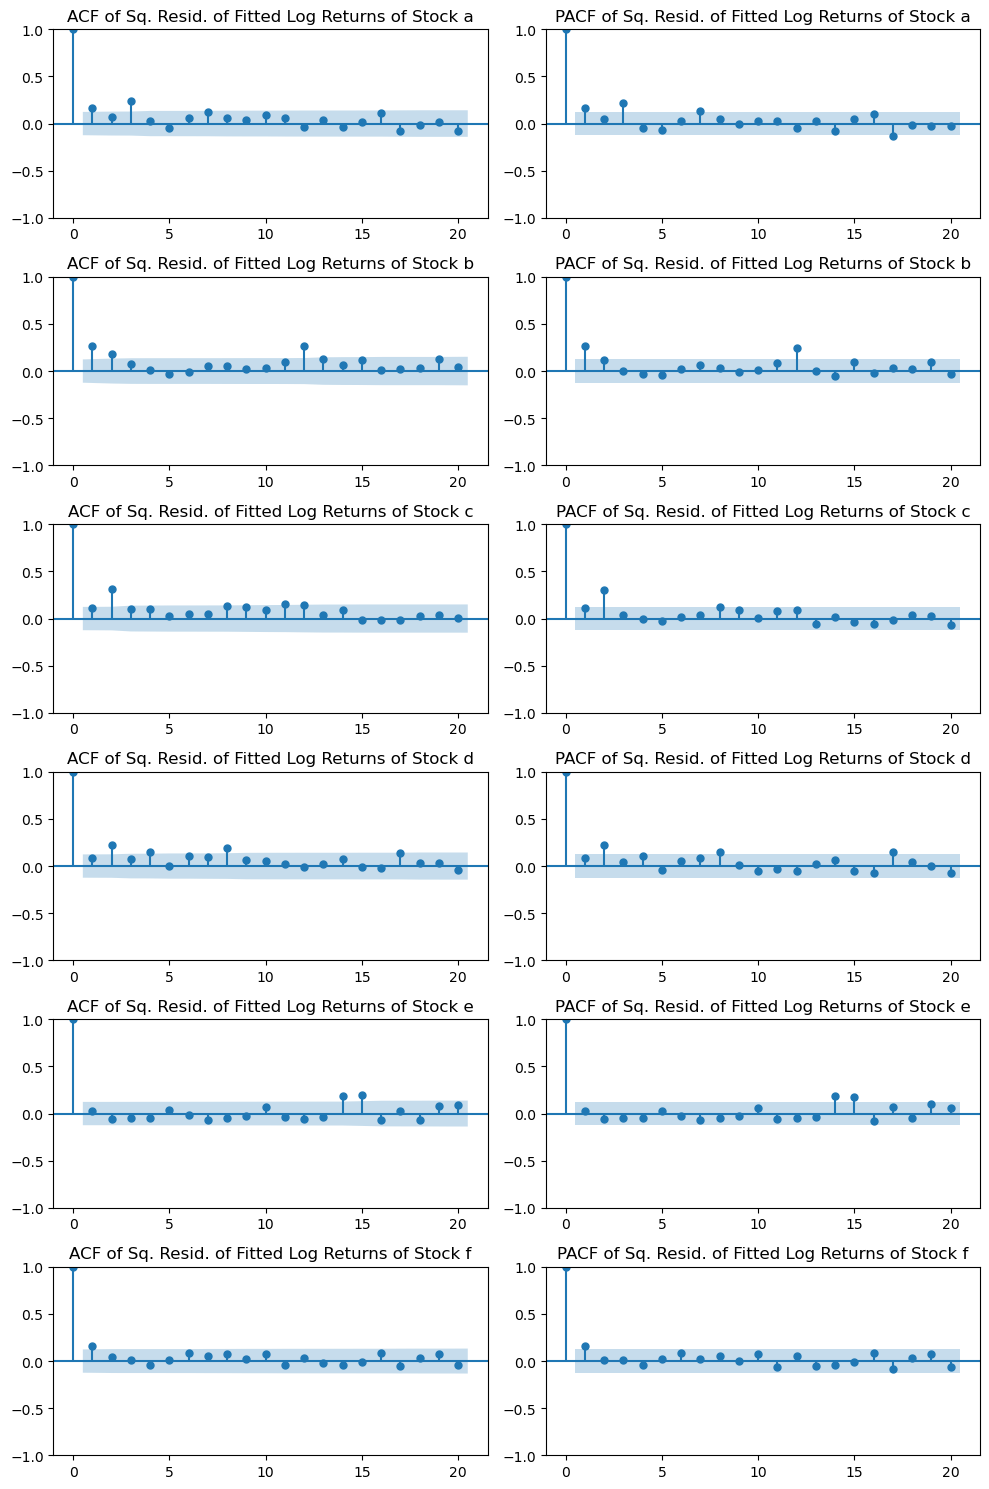

In [250]:
fig, axes = plt.subplots(6, 2, figsize=(10, 15))
axes = axes.flatten(order='F')

for i, stock in enumerate(stocks):
    residuals_squared = arma_models[stock].resid**2
    plot_acf(residuals_squared, ax=axes[i], lags=20)
    axes[i].set_title(f'ACF of Sq. Resid. of Fitted Log Returns of Stock {stock}')

    plot_pacf(residuals_squared, ax=axes[i+6], lags=20)
    axes[i+6].set_title(f'PACF of Sq. Resid. of Fitted Log Returns of Stock {stock}')
plt.tight_layout()
plt.show()

In [158]:
# for i, model in enumerate(arma_models):
for i, stock in enumerate(stocks):
    # Using het_arch on the residuals
    # test_stat, p_value, _, _ = het_arch(model.resid)
    test_stat, p_value, _, _ = het_arch(arma_models[stock].resid)
    print(f'Stock {stocks[i]}: Test statistic = {test_stat}, p-value = {p_value}')

Stock a: Test statistic = 24.560979606857558, p-value = 0.006242779399070216
Stock b: Test statistic = 22.135803752164534, p-value = 0.014427517692342936
Stock c: Test statistic = 30.893671646447864, p-value = 0.0006109224041488023
Stock d: Test statistic = 23.618180309351903, p-value = 0.008680983732488599
Stock e: Test statistic = 4.887187507866077, p-value = 0.8985853821846425
Stock f: Test statistic = 11.27523226201008, p-value = 0.33648082473622787


Our tests indicate there are likely ARCH effects in the log returns of Stocks a, b, c, and d. For Stocks e and f, the log returns look likely to be white noise, with the ACF and PACF graphs suggesting no higher AR effects and the fitted AR model having no parameter estimates that are significantly different from zero.

As we use the 'arch' package, which does not have an implementation of ARMA models for the conditional mean of a series but does have AR model implentations, we settle for approximating an (invertible) ARMA(p',q) model with an AR(p) model. We perform a grid search over hyperparameter values for both the AR(p) and EGARCH(r,o,s) components and use the AIC to determine the best model.

In [ ]:
p_range = range(1,5)
q_range = range(5)
lag_range = range(7)
o_range = range(1)

garch_models = grid_search_aic(r, p_range, q_range, lag_range=lag_range, o_range=o_range)

In [230]:
print(garch_models)

{'a':                           AR - EGARCH Model Results                           
Dep. Variable:                      a   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                693.245
Distribution:                  Normal   AIC:                          -1370.49
Method:            Maximum Likelihood   BIC:                          -1342.29
                                        No. Observations:                  251
Date:                Sun, May 05 2024   Df Residuals:                      250
Time:                        17:43:43   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
Const      5.7583e-04  7.707e-11  7.471e+06      0.0

In [231]:
forecasts = {stock: garch_models[stock].forecast(horizon=21, method='simulation', simulations=5000) for stock in stocks}

In [339]:
for stock in stocks:
    print(forecasts[stock].variance.iloc[0].values)

[0.02275756 0.02669651 0.02883413 0.0402864  0.03743944 0.03525098
 0.03311065 0.03123328 0.02906221 0.02738888 0.0256275  0.02425764
 0.02294076 0.02159415 0.02031564 0.01928405 0.01816351 0.01721987
 0.01626149 0.01541132 0.01466389]
[0.00058967 0.2164378  0.00309997 0.12054729 0.00216075 0.06017853
 0.0014572  0.03621897 0.00150743 0.02343595 0.00162597 0.01686371
 0.00188347 0.0124667  0.00209037 0.00984902 0.00232178 0.00792074
 0.00245624 0.00666606 0.00269026]
[1.73075934e-38 1.15944034e-24 8.96068079e-39 4.60949858e-26
 1.77050818e-38 6.15251638e-26 3.48105079e-38 8.25745473e-26
 6.79302342e-38 1.10665891e-25 1.31067397e-37 1.47147715e-25
 2.53146381e-37 1.97389738e-25 4.84457235e-37 2.62137882e-25
 9.21118707e-37 3.51099888e-25 1.74719659e-36 4.66780087e-25
 3.29790366e-36]
[0.0002304  0.0002281  0.00024869 0.00024838 0.00026512 0.00026695
 0.00028099 0.00028427 0.00029494 0.00029999 0.00031047 0.00031624
 0.00032517 0.0003286  0.00033427 0.00033623 0.00034165 0.00034679
 0.00

In [ ]:
# The model for Stock c experienced numerical issues, so we treat it separately. 
p_range = range(1,5)
q_range = range(5)
lag_range = range(7)

best_aic_c = float('inf')
best_model_c = None

# Create combinations of hyperparameters
hyperparams_c = product(lag_range, p_range, q_range)

for lag, p, q in hyperparams_c:
    # Fit EGARCH model to the residuals
    model_c = arch_model(r['c'], mean='AR', lags=lag, vol='GARCH', p=p, q=q, rescale=False)
    fitted_model_c = model_c.fit(disp='off', tol=1e-20, options={'maxiter':300})

    # Calculate AIC
    aic_c = fitted_model_c.aic

    # Update best model if lower AIC is found
    if aic_c < best_aic_c:
        best_aic_c = aic_c
        best_model_c = fitted_model_c
                    
model_c = best_model_c
model_c

In [357]:
model_c

                           AR - GARCH Model Results                           
Dep. Variable:                      c   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                603.303
Distribution:                  Normal   AIC:                          -1198.61
Method:            Maximum Likelihood   BIC:                          -1184.50
                                        No. Observations:                  251
Date:                Sun, May 05 2024   Df Residuals:                      250
Time:                        19:14:09   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const      4.6481e-04  1.229e-03      0.378      0.705 

In [335]:
def simulate(model, horizon=21, simulations=100):
    """ Simulate the given fitted model 'simulations' number of times in order
    to form prediction intervals """
    simulated_volatilities = np.zeros((horizon, simulations))
    
    for i in range(simulations):
        forecast = model.forecast(horizon=horizon, method='simulation', simulations=1)
        simulated_volatilities[:, i] = np.sqrt(forecast.variance.iloc[0])

    lower_bounds = np.percentile(simulated_volatilities, 2.5, axis=1)
    upper_bounds = np.percentile(simulated_volatilities, 97.5, axis=1)
    return simulated_volatilities, lower_bounds, upper_bounds

In [336]:
vols = {stock: simulate(garch_models[stock], simulations=1000) for stock in stocks}

In [344]:
vols['a'][1][20]

0.07662140919945405

In [ ]:
forecast_c = model_c.forecast(horizon=21, method='simulation', simulations=5000)

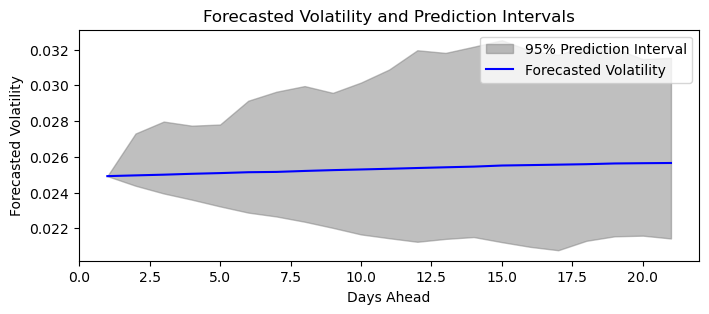

In [358]:
simulated_volatilities_c, low_c, high_c = simulate(model_c)

plt.figure(figsize=(8, 3))
plt.fill_between(range(1,22), low_c, high_c, color='gray', alpha=0.5, label='95% Prediction Interval')
plt.plot(range(1,22), np.sqrt(forecast_c.variance.iloc[0]), color='blue', label='Forecasted Volatility')
plt.title('Forecasted Volatility and Prediction Intervals')
plt.xlabel('Days Ahead')
plt.ylabel('Forecasted Volatility')
plt.legend()
plt.show()

In [356]:
def annualize(simulated_volatilities):
    
    annualized_vol_percent = simulated_volatilities*np.sqrt(252)*100
    
    return annualized_vol_percent

horizon = 21
for stock in stocks:
    if stock != 'c':
        vol = np.sqrt(forecasts[stock].variance.iloc[0].values[-1])
        print(f'Predicted volatility of log returns of Stock "{stock}" {horizon} trading days into future: {annualize(vol)}%')
        print(f'with 95% prediction interval: ({annualize(vols[stock][1][horizon-1])}%, {annualize(vols[stock][2][horizon-1])}%).\n')
    else:
        vol = np.sqrt(forecast_c.variance.iloc[0].values[-1])
        print(f'Predicted volatility of log returns of Stock {stock} {horizon} trading days into future: {annualize(vol)}%')
        print(f'with 95% prediction interval: ({annualize(low_c[horizon-1])}%, {annualize(high_c[horizon-1])}%).\n')
    

Predicted volatility of log returns of Stock "a" 21 trading days into future: 192.23166258100593%
with 95% prediction interval: (121.63271630704322%, 272.633244787763%).

Predicted volatility of log returns of Stock "b" 21 trading days into future: 82.33752009022602%
with 95% prediction interval: (38.477613066750315%, 151.2727030258212%).

Predicted volatility of log returns of Stock c 21 trading days into future: 40.726988831878785%
with 95% prediction interval: (32.720829034247714%, 51.23808779103768%).

Predicted volatility of log returns of Stock "d" 21 trading days into future: 30.163825109921767%
with 95% prediction interval: (16.124986824137615%, 51.057365921927996%).

Predicted volatility of log returns of Stock "e" 21 trading days into future: 36.34598691393421%
with 95% prediction interval: (24.315184256216494%, 47.18204315989566%).

Predicted volatility of log returns of Stock "f" 21 trading days into future: 38.76489625116524%
with 95% prediction interval: (24.0323941479270